# Prediction Progress #

We now consider an agent whose objective is not to predict correctly the class of the stimulus but to maximize some form of prediction progress. In this case, although the agent keeps receiving feedback about whether or not it predicted correctly a given stimulus, the agent does not take that into account to decide what tasks to solve. Instead we are interested in an agent that tracks the evolution of its predictions in order to decide which task to perform. 

The agent now considers how good or bad it is at predicting the classes of a given stimulus favoring those tasks in which it is making some form of progress. For instance, if an agent performs very well in certain task but has reached certain level in which no matter how well it performs it cannot improve its predictions any further, then the agent should proceed with another task where it can notice an increase in performance. Similarly, if the agent performs poorly in a task and continues to do so at the same level, then it should switch to another task. Basically, in this case we want an agent that maximizes a metric of progress as opposed to an external reward given after classifying correctly an stimulus.

More formally, in previous notebooks the estimates $\hat{Q(a)}$ referred to the expected reward $\mathbb{E}[R_a]$. In our exercise this was considered as the probability of succeding in a task and obtained simply by counting the number of successes divided by the total number of times the task has been selected. Let us refer to the probability of succeding in task $a$ as $P(s_a)$, thus for our new agent the reward is given by:

$$
R_a = \Delta P(s_a) = P(s_{a,t}) - P(s_{a,t-1})
$$

The difference between our current probability of success and our previous one in task $a$. In this case $t$ may not necessarily refer to the actual previous time step, but to the previous time the task $a$ was selected. The exploration strategies will now be guided by a new estimate $\hat{Q}(a)$:

$$
\hat{Q}(a) = \dfrac{1}{N} \sum_{i}^{N} R_{a,i}
$$

Where $N$ may be the entire history of rewards, or just a time window of previous observations.

In [141]:
%matplotlib inline
from __future__ import division
from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import multivariate_normal
from matplotlib.ticker import MaxNLocator

In [167]:
TASKS = 4

# For plotting the evolution of the accumulated rewards
def plotRew(rew, std, steps):
    ax = plt.figure(figsize=(12,9)).gca()
    labels = ['Random','Greedy','$\epsilon$-greedy','TS','UCB']
    colors = ['blue','red','black','orange','brown']
    for r in range(len(rew)):
        ax.plot(rew[r], '-', markersize=8, color=colors[r], alpha=0.5, label=labels[r], linewidth=2.5)
        plt.fill_between(range(len(rew[r])), rew[r]-std[r], rew[r]+std[r], facecolor=colors[r], alpha=0.15)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Cumulative reward')
    plt.xlabel('Time steps')
    plt.xlim(0, steps-1)
    plt.show()
    
def plotSelection(cpTask, coord):
    #print(coord[st])
    #ax = plt.figure().gca()
    axarr[coord].set_ylim([-.75, .9])
    axarr[coord].plot(np.array(cpTask[0])[1:,1],np.diff(np.array(cpTask[0])[:,0]), '-o', markersize=8, color='blue', alpha=0.5, label='Task 1', linewidth=2.5)
    axarr[coord].plot(np.array(cpTask[1])[1:,1],np.diff(np.array(cpTask[1])[:,0]), '-o', markersize=8, color='red', alpha=0.5, label='Task 2', linewidth=2.5)
    axarr[coord].plot(np.array(cpTask[2])[1:,1],np.diff(np.array(cpTask[2])[:,0]), '-o', markersize=8, color='black', alpha=0.5, label='Task 3', linewidth=2.5)
    axarr[coord].plot(np.array(cpTask[3])[1:,1],np.diff(np.array(cpTask[3])[:,0]), '-o', markersize=8, color='orange', alpha=0.5, label='Task 4', linewidth=2.5)
    axarr[coord].set_ylabel('Prediction Progress')
    axarr[coord].set_xlabel('Time steps')
    axarr[coord].set_title(plotNames[st])
    axarr[coord].legend(loc=3, fancybox=True, shadow=True, ncol=4)

def initPriors():
    classes = 2
    # Initalize observations for all p(y) with ones so initial p(y)'s = 0.5
    priors = np.ones((TASKS,classes))
    return priors

def initParameters():
    # Initialize parameters needed for likelihoods p(x|y) with mu=[0,..0] cov=identity matrix
    classes = 2
    mu = [[0]*classes for i in range(TASKS)]
    cov = [[0]*classes for i in range(TASKS)]
    for task in range(TASKS):
        for cl in range(classes):
            # Prior gaussian mu and covariance
            mu[task][cl] = np.zeros((classes)) #np.array([0,0])
            cov[task][cl] = np.eye(classes) #np.array([[1,0],[0,1]])
            np.fill_diagonal(cov[task][cl], 100)

    return [mu, cov]

def random(counts):
    # Get number of bandits
    numBandits = counts.shape[0]
    return np.random.randint(0,numBandits)

def eGreedy(counts, epsilon=0.1):
    # Get number of bandits
    numBandits = counts.shape[0]
    # Select random choice
    if np.random.random() < epsilon:
        action = np.random.randint(0, numBandits)
    # Or act greedily
    else:
        #print('greedy bastard ', counts[:,3])
        action = np.argmax(counts[:,3])
    return action

def UCB1(counts, step):
    # Get number of bandits
    numBandits = counts.shape[0]
    # Tunable hyperparameter
    c = 1
    # Store upper confidence bounds
    ucbs = []
    for i in range(numBandits):
        # Get number of times the bandit has been selected (at least once since they've been initialized)
        T = np.sum(counts[i,[0,1]])
        # Get mean(t-1) success for this arm (#success / #times arm has been played)
        mu = counts[i,0] / T #equivalent: mu = counts[i,2]
        # Calculate UCB
        # UCB_i(t) = mu_i(t-1) + c * sqrt[2 log t / T_i(t-1)]
        ucb = mu + (c * np.sqrt( (2*np.log(step+1)) / T ))
        ucbs.append(ucb)
    action = np.argmax(ucbs)
    return action

def thompsonSampling(counts):
    # Get number of bandits
    numBandits = counts.shape[0]
    # The prior is given by a beta distribution, so define prior on alpha and beta (i.e. Beta(a,B))
    # The bandits were initialized for now assuming the prior parameters are the same for all bandits
    alpha = 1
    beta = 1
    samples = []
    for i in range(numBandits):
        # Since it is conjugate we can just get the posterior with the counts and plug it into the distribution
        # Sample from the posterior p(R|History)
        posterior = np.random.beta(counts[i][0] + alpha, counts[i][1] + beta)
        #posterior = np.random.beta(counts[i][0], counts[i][1])
        samples.append(posterior)
    action = np.argmax(samples)
    return action

def selectAction(counts, strategy, step):
    if strategy == 'random':
        action = random(counts)
    elif strategy == 'greedy':
        action = eGreedy(counts, epsilon=0)
    elif strategy == 'eGreedy':
        action = eGreedy(counts)
    elif strategy == 'ucb':
        action = UCB1(counts,step)
    elif strategy == 'thompson':
        action = thompsonSampling(counts)
    return action

# Once the agent has selected a task, this function is called to sample a data point from one of the two distributions
# that are available for that task
def getSample(action):
    mu1 = [[0,0], [0,0], [10,0], [10,0]]
    mu2 = [[0,0], [0,0], [20,20], [10,5]]
    cov1 = [ [[1,0],[0,1]], [[40,10],[10,3]], [[100,0],[0,1]], [[100,0],[0,1]] ]
    cov2 = [ [[1,0],[0,1]], [[40,-10],[-10,3]], [[1,0],[0,1]], [[100,0],[0,1]] ]
    if np.random.random() > 0.5:
        mu = mu1[action]
        cov = cov1[action]
        category = 0
    else:
        mu = mu2[action]
        cov = cov2[action]
        category = 1
    sample = np.random.multivariate_normal(mu, cov)
    return sample, category

'''
This function simply tells us P(y=Class1|data point) and P(y=Class2|data point)
 action - the task or arm to select
 category - type of stimulus
 X - properties of the stimulus
 priors - prior observations [Task, Class] P(y) (in this case a 4 x 2 matrix)
 params - parameters for likelihoods P(x|y) corresponding to mu and covariance matrix ([mu, cov] each of size [Task, Class])
'''
def getPosterior(action, category, X, priors, params):

    mu, cov = params
    # get parameters to sample from the distributions [TASKS][CLASSES]
    # From first distribution
    mu1 = mu[action][0]
    cov1 = cov[action][0]
    # From second distribution
    mu2 = mu[action][1]
    cov2 = cov[action][1]

    # Likelihoods
    # p(x|mu1,cov1) or p(x=Data point|y=Class 1)
    pxgy1 = multivariate_normal.pdf(X, mean=mu1, cov=cov1)
    # p(x=Data point|y=Class 2)
    pxgy2 = multivariate_normal.pdf(X, mean=mu2, cov=cov2)

    # Priors
    # First get how many times this task has been observed in total
    numObs = priors[action][0] + priors[action][1]
    # p(y=Class {1,2}) (Number of times an object of class 1 (or 2) has been observed)
    # [TASKS][CLASSES]
    py1 = priors[action][0]/numObs #0.5
    py2 = priors[action][1]/numObs #0.5
    # Obtain marginal p(x)
    px = (pxgy1 * py1) + (pxgy2 * py2)
    # Posterior p(y|x)
    py1gx = (pxgy1 * py1) / px
    py2gx = (pxgy2 * py2) / px

    return [py1gx, py2gx]

def updateObs(action, category, X, priors, params, observations):
    # Update number of times a class of monster has been observed
    # [TASKS][CLASSES]
    priors[action][category] += 1

    # Get total number of observations
    numObs = priors[action][0] + priors[action][1]
    # Retrieve specific mean and covariance matrix to update
    mus, covs = params

    # Append new observations
    observations.append([action, category, X[0], X[1]])
    # Factor out
    data = np.array(observations)
    data = data[np.where((data[:,0]==action) * (data[:,1]==category))]
    data = data[:,2:4]
    # Get new mean
    newMu = np.mean(data, axis=0)
    # Update mean
    mus[action][category] = newMu
    # Get new covariance
    newCov = np.cov(data.T)

    # If it's the first observation we cannot really get the covariance yet and will just generate a matrix of NaNs
    # So only update the covariance if that's not the case otherwise keep the initial assumptions
    if data.shape[0] > 2:
        if not np.isnan(newCov).any():
            # Update covariance
            covs[action][category] = newCov

    # Pack parameters
    params = [mus, covs]
    return priors, params, observations

In [143]:
def observe(action, priors, params, observations):
    # Sample from the distribution of the task that has been selected in order to obtain a set of
    # properties X = [x_1, x_2] which correspond to sampling from the dimensions of the 2D gaussian and its label
    # category = y denoting from which of the gaussians it was sampled from
    X, category = getSample(action)
    # Get posterior distribution with predictions
    # This contains the probability the data point belongs to class 1 or class 2
    pyx = getPosterior(action, category, X, priors, params)
    # Sample from posterior to select one of the two options
    prediction = np.random.choice([0,1], p=pyx)
    # Verify if prediction is true or not
    if prediction == category:
        predCorrect = True
    else:
        predCorrect = False
    # Update observations according to sampleprio
    priors, params, observations = updateObs(action, category, X, priors, params, observations)
    return predCorrect, priors, params, observations

def simulate(numBandits, steps, strategy='greedy'):
    # Initialize prior probabilities
    priors = initPriors()
    # Get initial means and covariances
    params = initParameters()
    observations = []
    # Save total reward and action selected
    statistics = []
    totalPredCorr = 0
    totalReward = 0
    # Store observations about [successes, failures, prob of success, last change in probability of success]
    counts = np.ones((numBandits, 4)) #counts = np.zeros((numBandits, 3))
    # Stores total reward per task
    rewTask = np.zeros(numBandits)

    if strategy != 'ucb':
        # Accordingly, set initial probabilities of success with 0.5 for each arm except UCB since we'll set it below
        # ASSUMPTION: We also initialize change in probability of success to 0.5
        counts[:,2:] = 0.5

    # UCB1 requires additional initialization
    if strategy == 'ucb':
        # It needs to play each of the arms once
        for arm in range(numBandits):
            # Execute action and observe reward
            predCorrect, priors, params, observations = observe(arm, priors, params, observations)
            totalPredCorr += predCorrect
            statistics.append([totalReward, arm, totalPredCorr])
            # Update successes and failures for the bandit [(succ, fail) so 1-reward]
            counts[arm, 1-predCorrect] += 1
            # Update probability of success
            counts[arm, 2] = counts[arm, 0] / np.sum(counts[arm, [0,1]])
            # Initialize expected change in probability of success to initial probability of success
            counts[arm, 3] = counts[arm, 2]

    # For statistics
    actions = [] # Stores task selected by the strategy at each time step
    probs = np.zeros((numBandits, steps)) # Stores prob.s of success for every task at each time step
    succFail = [] # Stores cumulatives successes and failures
    countSF = 0

    # Exploration space dynamics
    acT = np.zeros(TASKS)
    expSpace = []

    # Capability to predict (learning progress)
    lpT = np.zeros(TASKS)
    leProg = []

    # To keep track in the change of probabilities and also the steps in which they change
    # It stores [probability of success, step, last difference]
    pt1, pt2, pt3, pt4 = [], [], [], []
    # Another ASSUMPTION start all probs to 0, so first time each task is selected the reward is the probability of success
    cpTask = [[[0,0]] for x in range(numBandits)]

    for step in range(steps):

        # Apply policy to get an action
        action = selectAction(counts, strategy, step)
        actions.append(action+1)

        # Execute action and observe outcome
        predCorrect, priors, params, observations = observe(action, priors, params, observations)
        totalPredCorr += predCorrect

        # Update successes and failures for the bandit [(succ, fail) so 1-reward]
        counts[action, 1-predCorrect] += 1
        # Store succ/fail
        if not predCorrect:
            countSF -= 1
        else:
            countSF += 1
        succFail.append(countSF)

        # Update probability of success
        counts[action, 2] = counts[action, 0] / np.sum(counts[action,[0,1]])
        # Store current p of success probs[action, step] update all of them for simplicity
        probs[:, step] = counts[:, 2]
        # Save task-specific statistics
        #cpTask[action].append([counts[action,2], step])
        cpTask[action].append([counts[action,2], step+1])

        change = np.diff(np.array(cpTask[action])[:,0])
        reward = change[-1]

        # Update total reward
        totalReward += reward
        # And total reward per task
        rewTask[action] += reward
        statistics.append([totalReward, action, totalPredCorr])

        # Update average change in probability of success
        # First get number of times the task has been selected (at least once since we updated above the selection of the action)
        if strategy == 'ucb':
            N_t = np.sum(counts[action,[0,1]]) - 3
        else:
            N_t = np.sum(counts[action,[0,1]]) - 2
        counts[action, 3] = rewTask[action] / N_t

        # Store stats
        # Time windows for action
        acT[action]+=1
        # Time windows for prediction ability
        lpT[action]+=predCorrect
        # Store every 10 steps
        if (step+1) % 10 == 0:
            expSpace.append(acT/10)
            acT[:] = 0
            lpT[:] = 0

    #for i in range(numBandits):
        #print(''.join( ["Task ", str(i+1),": ", str(np.shape(np.array(cpTask[i]))[0]), " ", str(np.shape(np.array(cpTask[i]))[0]/steps*100), "%" ] )) 

    return statistics, actions, probs, succFail, counts, expSpace, np.array(cpTask)

Random
Task 1 27.0
Task 2 24.0
Task 3 31.0
Task 4 22.0
('Total reward ', 2.7502795031055878)
Greedy
Task 1 21.0
Task 2 26.0
Task 3 30.0
Task 4 27.0
('Total reward ', 3.09334124656705)
e-Greedy
Task 1 18.0
Task 2 25.0
Task 3 29.0
Task 4 32.0
('Total reward ', 3.0631456263035197)
UCB1
Task 1 6.0
Task 2 31.0
Task 3 62.0
Task 4 5.0
('Total reward ', 2.1338609307359286)


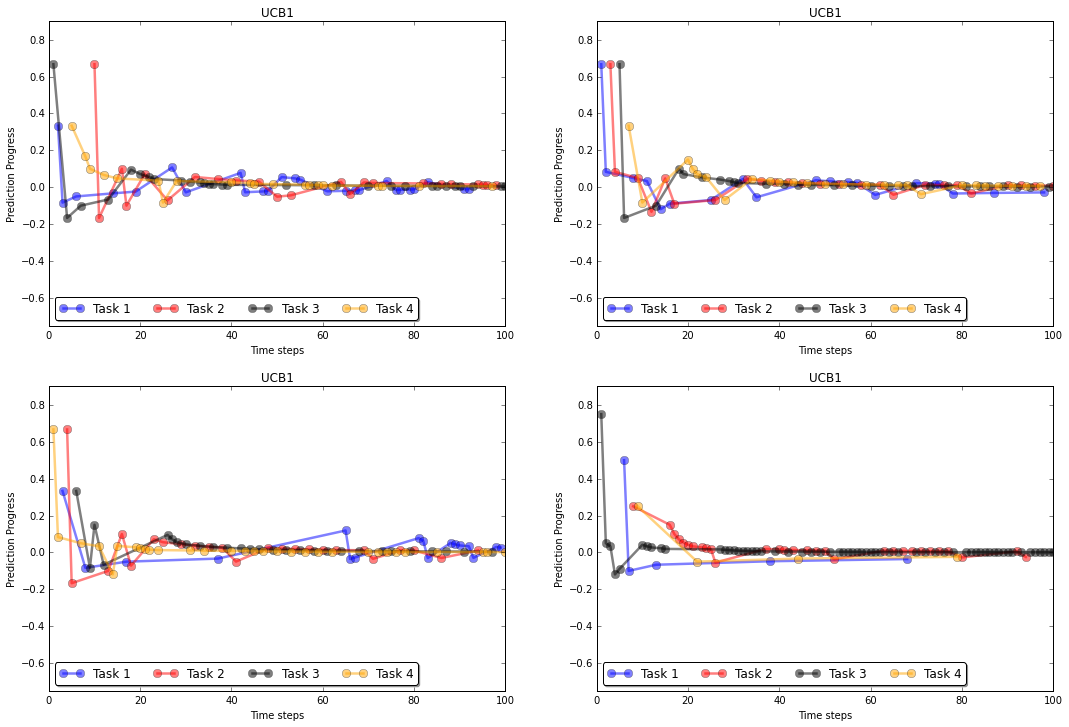

In [168]:
f, axarr = plt.subplots(2, 2, figsize=(18,12))
coord = [ (0,0),(0,1),(1,0),(1,1) ]
def run(repetitions, graph=False):
    # Number of arms or tasks
    numBandits = TASKS

    # Store collective history of successes and failures
    combSF = []

    # For how many steps to run the exercise?
    steps = 100

    # Store counts and total rewards
    cRnd, trRnd = [], []
    cGre, trGre = [], []
    cEG, trEG = [], []
    cTS, trTS = [], []
    cUCB, trUCB = [], []

    # Store exploration proportions
    ExpRnd, ExpGre, ExpEG, ExpTS, ExpUCB = [], [], [], [], []
    # Store probabilities of success
    ProbRnd, ProbGre, ProbEG, ProbTS, ProbUCB = [], [], [], [], []
    # Store evolution of rewards
    rewRnd, rewGre, rewEG, rewTS, rewUCB = [], [], [], [], []


    # strategies = ['random','greedy','eGreedy','thompson','ucb']
    # names = ['Rnd', 'Gre', 'EG', 'TS', 'UCB']
    # plotNames = ['Random', 'Greedy', 'e-Greedy', 'Thompson Sampling', 'UCB1']
    strategies = ['random','greedy','eGreedy', 'ucb']
    names = ['Rnd', 'Gre', 'EG', 'UCB']
    plotNames = ['Random', 'Greedy', 'e-Greedy', 'UCB1']
    
    #f, axarr = plt.subplots(2, 2, figsize=(18,12))
    #coord = [ (0,0),(0,1),(1,0),(1,1) ]
    selRnd, selGre, selEG, selUCB = [], [], [], []
    for st in range(len(strategies)):
        print(plotNames[st])
        # How many times to repeat it
        for rep in range(repetitions):

            #print(plotNames, " ==============")
            stats, actions, probs, sf, counts, expSpace, cpTask = simulate(numBandits, steps, strategy=strategies[st])

            combSF.append(sf)
            #print("Total reward and action selected:\n",stats)
            #print("Total reward and action selected ", stats[-1])
            # explorationDyn(actions, plotNames[st])
            #probDyn(probs, plotNames[st])
            #succFailDyn(sf, plotNames[st])
            var = ''.join(['c',names[st]])
            vars()[var].append(counts)
            var = ''.join(['tr',names[st]])
            vars()[var].append(stats[-1][0])
            var = ''.join(['Exp',names[st]])
            vars()[var].append(expSpace)
            var = ''.join(['Prob',names[st]])
            vars()[var].append(probs)

            #lpDyn(probs, plotNames[st])

            var = ''.join(['rew',names[st]])
            vars()[var].append(np.array(stats)[:,0])

            var = ''.join(['sel',names[st]])
            vars()[var].append([np.shape(cpTask[i])[0] for i in range(numBandits)])

        var = ''.join(['sel',names[st]])
        avgSelection = np.mean(np.array(vars()[var]), axis=0)
        tasksT = ["Task 1","Task 2","Task 3","Task 4"]
        for ta in range(len(tasksT)):
            print(''.join([tasksT[ta], ' ', str(avgSelection[ta])]))
        print("Total reward ", stats[-1][0])

        plotSelection(cpTask, coord[st])
        print("===============================================")
        
run(1, True)

In the plots above we observe an example of a trial for each of the strategies. Since only one task is selected at each time step, the circles represent when that specific task was selected.

The difference in cumulative reward is very small, and possibly a product of the general ignorance regarding the stimuli during the very early stages.

In [172]:
run(100, False)

Random
Task 1 26.18
Task 2 25.74
Task 3 25.31
Task 4 26.77
('Total reward ', 2.8371148459383746)
Greedy
Task 1 17.69
Task 2 24.6
Task 3 32.03
Task 4 29.68
('Total reward ', 3.040801564027368)
e-Greedy
Task 1 17.86
Task 2 24.94
Task 3 31.85
Task 4 29.35
('Total reward ', 2.854546781491754)
UCB1
Task 1 10.91
Task 2 17.05
Task 3 44.42
Task 4 31.62
('Total reward ', 2.7891283524904202)
